In [1]:
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier, Dataset, cv, train, early_stopping
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import __version__ as sklearn_version
from packaging import version
from multiprocessing import cpu_count
import numpy as np
import shap
import matplotlib.pyplot as plt
import polars as pl
import itertools
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Feature preprocessing 

In [2]:
### data preparation

#try:
#    comorbidities = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_comorbidity.csv')
#except FileNotFoundError:
#    print("Incorrect path to comorbidities file or comorbidities dataframe manipulation section not run first.")

try:
    adi_scores = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_adi_scores.csv')
except FileNotFoundError:
    print("Incorrect path to ADI scores file.")
try:
    labs = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_labs.csv')
except FileNotFoundError:
    print("Incorrect path to labs file.")
try:
    vitals = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_vitals.csv')
except FileNotFoundError:
    print("Incorrect path to vitals file.")
try:
    prior_infecting_organisms = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_culture_prior_infecting_organism.csv')
except FileNotFoundError:
    print("Incorrect path to prior infecting organisms file.")
try:
    subtype_exposure = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_antibiotic_subtype_exposure.csv')
except FileNotFoundError:
    print("Incorrect path to subtype exposure file.")
try:
    demographics = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_demographics.csv')
except FileNotFoundError:
    print("Incorrect path to demographics file.")
try:
    prior_med = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_prior_med.csv')
except FileNotFoundError:
    print("Incorrect path to prior medications file.")
try:
    prior_procedures = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_priorprocedures.csv')
except FileNotFoundError:
    print("Incorrect path to prior procedures file.")
try:
    ward_info = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_ward_info.csv')
except FileNotFoundError:
    print("Incorrect path to ward info file.")


try:
    microbial_resistance = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_microbial_resistance.csv')
except FileNotFoundError:
    print("Incorrect path to microbial resistance file.")


try:
    cohort = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_cohort.csv')
except FileNotFoundError:
    print("Incorrect path to cohort file.")
try:
    antibiotic_class_exposure = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_antibiotic_class_exposure.csv')
except FileNotFoundError:
    print("Incorrect path to antibiotic class exposure file.")
try:
    implied_susceptibility = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_implied_susceptibility.csv')
except FileNotFoundError:
   print("Incorrect path to implied susceptibility file.")


try:
    nursing_home_visits = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_nursing_home_visits.csv')
except FileNotFoundError:
    print("Incorrect path to nursing home visits file.")

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_58706/2067274398.py:9: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  adi_scores = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_adi_scores.csv')
/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_58706/2067274398.py:13: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  labs = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_labs.csv')
/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_58706/2067274398.py:17: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  vitals = pd.read_csv('/Users/fa/Documents/antimicrobial-susceptibility/microbiology_cultures_vitals.csv')
/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_58706/2067274398.py:29: DtypeWarning: Columns (4) 

In [138]:
## Model 1 
#only in patients and only for those were was posetive
#only for five selected ABX: 'Cefazolin', 'Ceftriaxone', 'Cefepime', 'Piperacillin/Tazobactam', 'Ciprofloxacin'

In [3]:
cohort = cohort[cohort['was_positive'] == 1]
cohort = cohort[cohort['ordering_mode'] == 'Inpatient']
cohort = cohort.drop(columns = ['ordering_mode', 'was_positive'])
cohort['year'] = [time[:4] for time in cohort['order_time_jittered_utc']]
cohort=cohort[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','order_time_jittered_utc','culture_description','year']]
cohort.drop_duplicates(inplace=True)
cohort.columns.values

array(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded',
       'order_time_jittered_utc', 'culture_description', 'year'],
      dtype=object)

In [4]:
implied_susceptibility=implied_susceptibility[(implied_susceptibility.organism!='Null')&(implied_susceptibility.antibiotic!='Null')]
implied_susceptibility.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,organism,antibiotic,susceptibility,implied_susceptibility
0,JC2673551,131337997983,831009441,ENTEROBACTER CLOACAE COMPLEX,imipenem,Null,Susceptible
1,JC616267,131007285560,358749950,ENTEROBACTER CLOACAE,imipenem,Null,Null
2,JC517471,131024758159,420255585,ENTEROBACTER ASBURIAE,doripenem,Null,Null
3,JC1931399,131200817434,512398445,MYCOBACTERIUM AVIUM COMPLEX,Clarithromycin,Susceptible,Null
4,JC605042,131280233261,642349435,KLEBSIELLA OXYTOCA,Ceftolozane/Tazobactam,Susceptible,Null


In [5]:

implied_susceptibility=implied_susceptibility[(implied_susceptibility.susceptibility!='Null')|(implied_susceptibility.implied_susceptibility!='Null')]
implied_susceptibility

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,organism,antibiotic,susceptibility,implied_susceptibility
0,JC2673551,131337997983,831009441,ENTEROBACTER CLOACAE COMPLEX,imipenem,Null,Susceptible
3,JC1931399,131200817434,512398445,MYCOBACTERIUM AVIUM COMPLEX,Clarithromycin,Susceptible,Null
4,JC605042,131280233261,642349435,KLEBSIELLA OXYTOCA,Ceftolozane/Tazobactam,Susceptible,Null
5,JC629724,131351986580,879371566,MUCOID PSEUDOMONAS AERUGINOSA,Ceftolozane/Tazobactam,Susceptible,Null
6,JC3257556,131010622629,373718233,KLEBSIELLA PNEUMONIAE,Trimethoprim/Sulfamethoxazole,Susceptible,Null
...,...,...,...,...,...,...,...
1978726,JC1968782,131346538225,887998404,ESCHERICHIA COLI,Amoxicillin/Clavulanic Acid,Susceptible,Null
1978727,JC1891401,131188090635,495913749,ESCHERICHIA COLI,Amoxicillin/Clavulanic Acid,Susceptible,Null
1978728,JC680569,131185719166,493570373,ESCHERICHIA COLI,Amoxicillin/Clavulanic Acid,Susceptible,Null
1978729,JC1242317,131213796632,514827508,ESCHERICHIA COLI,Amoxicillin/Clavulanic Acid,Susceptible,Null


In [6]:
implied_susceptibility = implied_susceptibility[implied_susceptibility['antibiotic'].isin(['Cefazolin', 'Ceftriaxone', 'Cefepime', 'Piperacillin/Tazobactam', 'Ciprofloxacin'])]
implied_susceptibility.loc[
    implied_susceptibility['implied_susceptibility'] == 'Null', 
    'implied_susceptibility'
] = implied_susceptibility['susceptibility']
implied_susceptibility=implied_susceptibility[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','organism','antibiotic','implied_susceptibility']]
implied_susceptibility=implied_susceptibility[implied_susceptibility.implied_susceptibility.isin(['Susceptible', 'Resistant','Non Susceptible'])]
implied_susceptibility.loc[implied_susceptibility.implied_susceptibility=='Non Susceptible',
                           'implied_susceptibility'
                           ]='Resistant'
implied_susceptibility.implied_susceptibility.unique()

array(['Susceptible', 'Resistant'], dtype=object)

In [7]:
df = cohort.merge(implied_susceptibility, on = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'], how = 'left')
df = df[df['implied_susceptibility'].isin(['Susceptible', 'Resistant'])]
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible


In [8]:
df = df.merge(demographics, on = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'], how = 'left')
df.loc[df.age=='Null','age']=None
df.loc[df.gender=='Null','gender']=None
df.loc[df.gender=='0','gender']=0
df.loc[df.gender=='1','gender']=1
#df['gender']=df['gender'].astype(int)
df.loc[df.age=='18–24 years','age']=1
df.loc[df.age=='25–34 years','age']=2
df.loc[df.age=='35–44 years','age']=3
df.loc[df.age=='45-54 years','age']=4
df.loc[df.age=='55-64 years','age']=5
df.loc[df.age=='65-74 years','age']=6
df.loc[df.age=='75-84 years','age']=7
df.loc[df.age=='85-89 years','age']=8
df.loc[df.age=='above 90','age']=9
df['age']=df['age'].astype(int)
df.age.unique()



array([7, 3, 6, 5, 4, 9, 8, 2, 1])

In [9]:
ward_info=ward_info[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','hosp_ward_IP','hosp_ward_OP','hosp_ward_ER','hosp_ward_ICU']]
ward_info.drop_duplicates(inplace=True)
for col in ward_info.columns.values:
    ward_info.loc[ward_info[col]=='Null',col]=None
ward_info.hosp_ward_IP.unique()



array([0., 1.])

In [10]:
adi_scores=adi_scores[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','adi_score']]
adi_scores.drop_duplicates(inplace=True)
for col in adi_scores.columns.values:
    adi_scores.loc[adi_scores[col]=='Null',col]=None
adi_scores.adi_score.unique()

array([None, '1', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
      dtype=object)

In [11]:
df = df.merge(ward_info, on = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'], how = 'left')
df = df.merge(adi_scores, on = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'], how = 'left')
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,gender,hosp_ward_IP,hosp_ward_OP,hosp_ward_ER,hosp_ward_ICU,adi_score
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,0,1.0,0.0,1.0,0.0,2
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,0,1.0,0.0,1.0,0.0,2
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,0,1.0,0.0,1.0,0.0,2
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,0,1.0,0.0,1.0,0.0,2
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,1,1.0,0.0,0.0,0.0,31


In [12]:
for col in vitals.columns.values:
    if not col in ['anon_id','pat_enc_csn_id_coded','order_proc_id_coded']:
        vitals.loc[vitals[col]=='Null',col]=None
        vitals[col]=vitals[col].astype('float')
vitals.head()


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,Q25_heartrate,Q75_heartrate,median_heartrate,Q25_resprate,Q75_resprate,median_resprate,Q25_temp,...,first_diasbp,last_diasbp,last_sysbp,first_sysbp,last_temp,first_temp,last_resprate,first_resprate,last_heartrate,first_heartrate
0,JC2361817,131308278530,718222807,86.0,86.0,86.0,NaN,NaN,NaN,NaN,...,NaN,80.0,109.0,NaN,NaN,NaN,NaN,NaN,NaN,86.0
1,JC2219930,131318072067,748261410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,75.0,75.0,121.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN
2,JC2455425,131256420868,574712812,70.0,70.0,70.0,NaN,NaN,NaN,NaN,...,69.0,NaN,NaN,106.0,NaN,NaN,NaN,NaN,70.0,NaN
3,JC1826078,131213257732,514463599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,90.0,90.0,120.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN
4,JC1541734,131021676805,410407692,39.0,78.0,73.0,NaN,NaN,NaN,NaN,...,NaN,42.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,80.0


In [13]:
df = df.merge(vitals, on = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'], how = 'left')

In [14]:
nursing_home_visits=nursing_home_visits[nursing_home_visits.nursing_home_visit_culture>=0]
nursing_home_visits['nursing_home_visits_within6month']=nursing_home_visits['nursing_home_visit_culture'].apply(lambda x: 1 if  x <= 180 else 0)
nursing_home_visits=nursing_home_visits[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','nursing_home_visits_within6month']]
nursing_home_visits = nursing_home_visits.groupby(['anon_id','pat_enc_csn_id_coded','order_proc_id_coded']).agg(
    nursing_visits_within_6mo =('nursing_home_visits_within6month', sum),
).reset_index()
nursing_home_visits['nursing_visits_within_6mo']=nursing_home_visits['nursing_visits_within_6mo'].astype(int)

df = df.merge(nursing_home_visits, on = ['anon_id','pat_enc_csn_id_coded','order_proc_id_coded'], how = 'left')
df.head()

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_58706/2576777276.py:4: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  nursing_home_visits = nursing_home_visits.groupby(['anon_id','pat_enc_csn_id_coded','order_proc_id_coded']).agg(


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,last_diasbp,last_sysbp,first_sysbp,last_temp,first_temp,last_resprate,first_resprate,last_heartrate,first_heartrate,nursing_visits_within_6mo
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,61.0,121.0,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,...,61.0,121.0,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,...,61.0,121.0,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,...,61.0,121.0,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
prior_procedures=prior_procedures[(prior_procedures.procedure_description!='Null')&(prior_procedures.procedure_description.notna())]
prior_procedures=prior_procedures[(prior_procedures.procedure_time_to_culturetime.notna())&(prior_procedures.procedure_time_to_culturetime!='Null')]
prior_procedures=prior_procedures[(prior_procedures.procedure_time_to_culturetime>=0)&(prior_procedures.procedure_time_to_culturetime<=180)]
procedures = prior_procedures.procedure_description.unique()

for procedure in procedures:
    prior_procedures[f"{procedure}_within_6mo"] = prior_procedures[prior_procedures['procedure_description'] == procedure]['procedure_time_to_culturetime'].apply(lambda x: 1 if x <= 180 else 0)
    

columns_to_sum = ['urethral_catheter_within_6mo','surgical_procedure_within_6mo','mechvent_within_6mo','cvc_within_6mo','parenteral_nutrition_within_6mo','dialysis_within_6mo']
agg_dict = {col: (col, 'sum') for col in columns_to_sum}
prior_procedures = prior_procedures.groupby(['anon_id','pat_enc_csn_id_coded','order_proc_id_coded']).agg(**agg_dict).reset_index() 
prior_procedures=prior_procedures[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','urethral_catheter_within_6mo','surgical_procedure_within_6mo','mechvent_within_6mo','cvc_within_6mo','parenteral_nutrition_within_6mo','dialysis_within_6mo']]
prior_procedures.drop_duplicates(inplace=True)
for col in ['urethral_catheter_within_6mo','surgical_procedure_within_6mo','mechvent_within_6mo','cvc_within_6mo','parenteral_nutrition_within_6mo','dialysis_within_6mo']:
    prior_procedures[col]=prior_procedures[col].astype(int)
prior_procedures

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,urethral_catheter_within_6mo,surgical_procedure_within_6mo,mechvent_within_6mo,cvc_within_6mo,parenteral_nutrition_within_6mo,dialysis_within_6mo
0,JC1000129,131348917413,855365600,2,0,0,0,0,0
1,JC1000129,131354606122,876959985,3,0,0,0,0,0
2,JC1000129,131354606122,876959986,3,0,0,0,0,0
3,JC1000129,131359337847,894465321,1,0,0,0,0,0
4,JC1000143,131266832987,606756716,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
156066,JC999754,131002270171,354437985,0,0,1,0,0,0
156067,JC999754,131002270171,354437986,0,0,1,0,0,0
156068,JC999793,131020075354,405267728,0,1,0,0,0,0
156069,JC999842,131192863784,500208763,0,0,0,0,0,1


In [16]:
df = df.merge(prior_procedures, on =['anon_id','pat_enc_csn_id_coded','order_proc_id_coded'], how = 'left')
df.iloc[:,42:]=df.iloc[:,42:].fillna(0)
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,first_resprate,last_heartrate,first_heartrate,nursing_visits_within_6mo,urethral_catheter_within_6mo,surgical_procedure_within_6mo,mechvent_within_6mo,cvc_within_6mo,parenteral_nutrition_within_6mo,dialysis_within_6mo
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,18.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,...,18.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,...,18.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,...,18.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,...,NaN,NaN,NaN,NaN,0.0,1.0,0.0,1.0,0.0,0.0


In [17]:
microbial_resistance=microbial_resistance[(microbial_resistance.organism!='Null')&(microbial_resistance.organism.notna())]
microbial_resistance=microbial_resistance[(microbial_resistance.antibiotic!='Null')&(microbial_resistance.antibiotic.notna())]
microbial_resistance=microbial_resistance[(microbial_resistance.resistant_time_to_culturetime>=0)&(microbial_resistance.resistant_time_to_culturetime<=180)]
microbial_resistance=microbial_resistance[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','organism','antibiotic']]

# microbial resistance (game changer)
microbial_resistance = microbial_resistance[microbial_resistance['antibiotic'].isin(['Cefazolin', 'Ceftriaxone', 'Cefepime', 'Piperacillin/Tazobactam', 'Ciprofloxacin'])]
# filter for top 10 most common microbes
microbial_resistance = microbial_resistance[microbial_resistance['organism'].isin(['ESCHERICHIA COLI', 'PSEUDOMONAS AERUGINOSA', 'MUCOID PSEUDOMONAS AERUGINOSA', 
                                                                                   'KLEBSIELLA PNEUMONIAE', 'ACHROMOBACTER XYLOSOXIDANS', 'STAPHYLOCOCCUS AUREUS', 
                                                                                   'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)', 'ENTEROCOCCUS SPECIES', 'ENTEROBACTER CLOACAE COMPLEX', 'PROTEUS MIRABILIS'])]

microbial_resistance.drop_duplicates(inplace=True)
microbial_resistance['organism_resistance_antibiotic'] = microbial_resistance['organism'] + '_' + microbial_resistance['antibiotic']
microbial_resistance=microbial_resistance[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','organism_resistance_antibiotic']]
microbial_resistance.drop_duplicates(inplace=True)


In [18]:
microbial_resistance = microbial_resistance.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", "organism_resistance_antibiotic"])\
              .size()\
              .unstack(fill_value=0)\
              .reset_index()
microbial_resistance.columns.name = None  # Remove hierarchical index from unstack
print(microbial_resistance)


         anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0      JC1000129          131348917413            855365600   
1      JC1000129          131354606122            876959985   
2      JC1000129          131354606122            876959986   
3      JC1000129          131359337847            894465321   
4      JC1000169          131186502229            494269657   
...          ...                   ...                  ...   
58221   JC999695          131238748562            536694630   
58222   JC999695          131238748562            536694632   
58223   JC999695          131240032823            539891925   
58224   JC999695          131240032823            539891927   
58225   JC999695          131240032823            539891931   

       ACHROMOBACTER XYLOSOXIDANS_Cefazolin  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4       

In [19]:
df = df.merge(microbial_resistance, on = ['anon_id','pat_enc_csn_id_coded','order_proc_id_coded'], how = 'left')
df.iloc[:, 48:] = df.iloc[:, 48:].fillna(0)
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,PROTEUS MIRABILIS_Ceftriaxone,PROTEUS MIRABILIS_Ciprofloxacin,PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Cefepime,PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Ciprofloxacin,PSEUDOMONAS AERUGINOSA_Cefazolin,PSEUDOMONAS AERUGINOSA_Cefepime,PSEUDOMONAS AERUGINOSA_Ceftriaxone,PSEUDOMONAS AERUGINOSA_Ciprofloxacin,STAPHYLOCOCCUS AUREUS_Cefazolin,STAPHYLOCOCCUS AUREUS_Ciprofloxacin
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
prior_infecting_organisms=prior_infecting_organisms[(prior_infecting_organisms.prior_infecting_organism_days_to_culutre<=180)&
                                                    (prior_infecting_organisms.prior_infecting_organism_days_to_culutre>=0)]

prior_infecting_organisms=prior_infecting_organisms[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','prior_organism']]
prior_infecting_organisms.drop_duplicates(inplace=True)
prior_infecting_organisms

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,prior_organism
0,JC1000055,131007833415,360359154,Escherichia
4,JC1000129,131348917413,855365600,Escherichia
6,JC1000129,131359337847,894465321,Escherichia
8,JC1000129,131359337847,894465321,Proteus
11,JC1000169,131216209091,516543570,Escherichia
...,...,...,...,...
1084087,JC999190,131362324212,907799972,Escherichia
1084091,JC999190,131365356752,915878692,Klebsiella
1084097,JC999190,131365356752,915878693,Klebsiella
1084110,JC999396,131246456560,552045783,Staphylococcus


In [21]:
prior_infecting_organisms = prior_infecting_organisms.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", "prior_organism"])\
              .size()\
              .unstack(fill_value=0)\
              .reset_index()
prior_infecting_organisms.columns.name = None  # Remove hierarchical index from unstack
prior_infecting_organisms.columns = [f"prior_infected_{col}" if 3 <= i <= 19 else col for i, col in enumerate(prior_infecting_organisms.columns)]
prior_infecting_organisms = prior_infecting_organisms[prior_infecting_organisms.iloc[:, 3:20].gt(0).any(axis=1)]
print(prior_infecting_organisms)


          anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0       JC1000055          131007833415            360359154   
1       JC1000083          131013906068            384652929   
2       JC1000129          131348917413            855365600   
3       JC1000129          131354606122            876959985   
4       JC1000129          131354606122            876959986   
...           ...                   ...                  ...   
105248   JC999695          131238748562            536694630   
105249   JC999695          131238748562            536694632   
105250   JC999695          131240032823            539891925   
105251   JC999695          131240032823            539891927   
105252   JC999695          131240032823            539891931   

        prior_infected_Acinetobacter  prior_infected_CONS  \
0                                  0                    0   
1                                  0                    0   
2                                  0            

In [22]:
df = df.merge(prior_infecting_organisms, on = ['anon_id','pat_enc_csn_id_coded','order_proc_id_coded'], how = 'left')
df.iloc[:, 79:] = df.iloc[:, 79:].fillna(0)
df.drop_duplicates(inplace=True)
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,prior_infected_Escherichia,prior_infected_Klebsiella,prior_infected_Morganella,prior_infected_Proteus,prior_infected_Providencia,prior_infected_Pseudomonas,prior_infected_Serratia,prior_infected_Staphylococcus,prior_infected_Stenotrophomonas,prior_infected_Streptococcus
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
prior_med=prior_med[(prior_med.medication_time_to_culturetime>=0)&(prior_med.medication_time_to_culturetime<=180)]
prior_med=prior_med[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','medication_name']]
prior_med.drop_duplicates(inplace=True)
prior_med

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,medication_name
2,JC1005213,131242737476,546059312,Amikacin
6,JC1018201,131007178838,359199842,Ceftazidime
33,JC1021489,131327676051,777953629,Ceftazidime
40,JC1024438,131011766132,376285814,Amikacin
41,JC1024438,131013577021,383561655,Amikacin
...,...,...,...,...
1952236,JC996143,131277304890,633314762,Metronidazole
1952237,JC996143,131280542195,643440579,Metronidazole
1952245,JC996586,131272547011,619378568,Metronidazole
1952247,JC997437,131024632565,419963109,Metronidazole


In [24]:
prior_med = prior_med.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", "medication_name"])\
              .size()\
              .unstack(fill_value=0)\
              .reset_index()
prior_med.columns.name = None  # Remove hierarchical index from unstack
prior_med.columns = [f"prior_med_{col}" if 3 <= i <= 23 else col for i, col in enumerate(prior_med.columns)]
prior_med = prior_med[prior_med.iloc[:, 3:23].gt(0).any(axis=1)]
print(prior_med)

          anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0       JC1000116          131066472308            456109964   
1       JC1000129          131359337847            894465321   
2       JC1000143          131312409361            730719899   
3       JC1000158          131261491919            587869265   
4       JC1000158          131261491919            587869266   
...           ...                   ...                  ...   
193849   JC999744          131208988464            511211017   
193850   JC999842          131192863784            500208763   
193851   JC999893          131303586651            708591987   
193852   JC999893          131320319431            761441463   
193853   JC999908          131189316002            496947265   

        prior_med_Amikacin  prior_med_Ampicillin  prior_med_Aztreonam  \
0                        0                     0                    0   
1                        0                     0                    0   
2           

In [25]:
df = df.merge(prior_med, on = ['anon_id','pat_enc_csn_id_coded','order_proc_id_coded'],how='left')
df.iloc[:, 95:] = df.iloc[:, 95:].fillna(0)
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,prior_med_Colistin,prior_med_Ertapenem,prior_med_Gentamicin,prior_med_Isoniazid,prior_med_Levaquin,prior_med_Levofloxacin,prior_med_Linezolid,prior_med_Metronidazole,prior_med_Penicillin,prior_med_Vancomycin
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
antibiotic_class_exposure=antibiotic_class_exposure[(antibiotic_class_exposure.time_to_culturetime>=0)&(antibiotic_class_exposure.time_to_culturetime<=180)]
antibiotic_class_exposure=antibiotic_class_exposure[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','antibiotic_class']]
antibiotic_class_exposure.drop_duplicates(inplace=True)
antibiotic_class_exposure

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,antibiotic_class
3,JC1965436,131350616952,861761841,Antitubercular
5,JC1409554,131022617974,413869070,Beta Lactam
8,JC1285316,131283292381,652260365,Beta Lactam
12,JC3062520,131301082479,700865647,Oxazolidinone
25,JC1324289,131013992116,386702169,Fluoroquinolone
...,...,...,...,...
12019115,JC584847,131363834625,910300541,Glycopeptide
12019122,JC6333022,131365945904,918258413,Glycopeptide
12019162,JC920568,131354262097,875645898,Glycopeptide
12019200,JC6303357,131362089315,916885821,Glycopeptide


In [28]:
antibiotic_class_exposure = antibiotic_class_exposure.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", "antibiotic_class"])\
              .size()\
              .unstack(fill_value=0)\
              .reset_index()
antibiotic_class_exposure.columns.name = None  # Remove hierarchical index from unstack
antibiotic_class_exposure.columns = [f"prior_abx_class_{col}" if 3 <= i else col for i, col in enumerate(antibiotic_class_exposure.columns)]
print(antibiotic_class_exposure)

          anon_id  pat_enc_csn_id_coded  order_proc_id_coded  \
0       JC1000063          131011127694            373759075   
1       JC1000116          131066472308            456109964   
2       JC1000129          131348917413            855365600   
3       JC1000129          131354606122            876959985   
4       JC1000129          131354606122            876959986   
...           ...                   ...                  ...   
481597   JC999893          131303586651            708591987   
481598   JC999893          131320319431            761441463   
481599   JC999908          131189316002            496947265   
481600   JC999925          131107270857            471989931   
481601   JC999992          131189547541            497201103   

        prior_abx_class_Aminoglycoside  prior_abx_class_Ansamycin  \
0                                    0                          0   
1                                    0                          0   
2                       

In [29]:
df = df.merge(antibiotic_class_exposure, on = ['anon_id','pat_enc_csn_id_coded','order_proc_id_coded'], how = 'left')
df.iloc[:, 115:] = df.iloc[:, 115:].fillna(0)
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,prior_abx_class_Glycopeptide,prior_abx_class_Macrolide Lincosamide,prior_abx_class_Monobactam,prior_abx_class_Nitrofuran,prior_abx_class_Nitroimidazole,prior_abx_class_Oxazolidinone,"prior_abx_class_Polymyxin, Lipopeptide",prior_abx_class_Sulfonamide,prior_abx_class_Tetracycline,prior_abx_class_Urinary Antiseptic
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df = df.merge(labs, on = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'], how = 'left')
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,last_plt,first_plt,last_hgb,first_hgb,last_lymphocytes,first_lymphocytes,last_neutrophils,first_neutrophils,last_wbc,first_wbc
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,...,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,...,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,...,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,...,66.9,Null,66.9,Null,66.9,Null,66.9,Null,Null,4.5


In [32]:
df.drop_duplicates(inplace=True)
df.shape#5123204

(5123204, 189)

In [33]:
df.to_csv('Model1.csv',index=False)

In [ ]:
# Model Development 

In [6]:
df=pd.read_csv('Model1.csv')
df.head()

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_71033/594518056.py:1: DtypeWarning: Columns (134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,168,171,173,174,175,177,178,179,181,183,185) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Model1.csv')


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,last_plt,first_plt,last_hgb,first_hgb,last_lymphocytes,first_lymphocytes,last_neutrophils,first_neutrophils,last_wbc,first_wbc
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,...,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,...,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,...,Null,Null,Null,Null,Null,Null,Null,Null,Null,Null
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,...,66.9,Null,66.9,Null,66.9,Null,66.9,Null,Null,4.5


In [32]:
categorical_features=['culture_description','antibiotic','implied_susceptibility']
numeric_features=['age','gender','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER',
       'hosp_ward_ICU', 'adi_score', 'Q25_heartrate', 'Q75_heartrate',
       'median_heartrate', 'Q25_resprate', 'Q75_resprate',
       'median_resprate', 'Q25_temp', 'Q75_temp', 'median_temp',
       'Q25_sysbp', 'Q75_sysbp', 'median_sysbp', 'Q25_diasbp',
       'Q75_diasbp','median_diasbp', 'first_diasbp', 'last_diasbp', 'last_sysbp',
       'first_sysbp', 'last_temp', 'first_temp', 'last_resprate',
       'first_resprate', 'last_heartrate', 'first_heartrate',
       'nursing_visits_within_6mo', 'urethral_catheter_within_6mo',
       'surgical_procedure_within_6mo', 'mechvent_within_6mo',
       'cvc_within_6mo', 'parenteral_nutrition_within_6mo',
       'dialysis_within_6mo', 
       'prior_med_Amikacin', 'prior_med_Ampicillin',
       'prior_med_Aztreonam', 'prior_med_Cefazolin', 'prior_med_Cefepime','prior_med_Cefoxitin', 'prior_med_Ceftazidime',
       'prior_med_Ceftriaxone', 'prior_med_Cipro',
       'prior_med_Ciprofloxacin', 'prior_med_Colistin',
       'prior_med_Ertapenem', 'prior_med_Gentamicin',
       'prior_med_Isoniazid', 'prior_med_Levaquin',
       'prior_med_Levofloxacin', 'prior_med_Linezolid',
       'prior_med_Metronidazole', 'prior_med_Penicillin',
       'prior_med_Vancomycin', 'prior_abx_class_Aminoglycoside',
       'prior_abx_class_Ansamycin', 'prior_abx_class_Antitubercular',
       'prior_abx_class_Beta Lactam',
       'prior_abx_class_Combination Antibiotic',
       'prior_abx_class_Fluoroquinolone',
       'prior_abx_class_Folate Synthesis Inhibitor',
       'prior_abx_class_Fosfomycin', 'prior_abx_class_Glycopeptide',
       'prior_abx_class_Macrolide Lincosamide',
       'prior_abx_class_Monobactam', 'prior_abx_class_Nitrofuran',
       'prior_abx_class_Nitroimidazole', 'prior_abx_class_Oxazolidinone',
       'prior_abx_class_Polymyxin, Lipopeptide','prior_abx_class_Sulfonamide', 'prior_abx_class_Tetracycline',
       'prior_abx_class_Urinary Antiseptic', 'Period_Day', 'Q75_wbc',
       'Q25_wbc', 'median_wbc', 'Q25_neutrophils', 'Q75_neutrophils',
       'median_neutrophils', 'Q25_lymphocytes', 'Q75_lymphocytes',
       'median_lymphocytes', 'Q25_hgb', 'Q75_hgb', 'median_hgb',
       'Q25_plt', 'Q75_plt', 'median_plt', 'Q75_na', 'Q25_na',
       'median_na', 'Q75_hco3', 'Q25_hco3', 'median_hco3', 'Q75_bun',
       'Q25_bun', 'median_bun', 'Q75_cr', 'Q25_cr','median_cr', 'Q75_lactate', 'Q25_lactate', 'median_lactate',
       'Q75_procalcitonin', 'Q25_procalcitonin', 'median_procalcitonin',
       'first_procalcitonin', 'last_procalcitonin', 'last_lactate',
       'first_lactate', 'last_cr', 'first_cr', 'last_bun', 'first_bun',
       'last_hco3', 'first_hco3', 'last_na', 'first_na', 'last_plt',
       'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc', 'prior_infected_Acinetobacter', 'prior_infected_CONS',
       'prior_infected_Candida', 'prior_infected_Citrobacter',
       'prior_infected_Enterobacter', 'prior_infected_Enterococcus',
       'prior_infected_Escherichia', 'prior_infected_Klebsiella',
       'prior_infected_Morganella', 'prior_infected_Proteus',
       'prior_infected_Providencia', 'prior_infected_Pseudomonas',
       'prior_infected_Serratia', 'prior_infected_Staphylococcus',
       'prior_infected_Stenotrophomonas', 'prior_infected_Streptococcus'
       ]
"""
'ACHROMOBACTER XYLOSOXIDANS_Cefazolin',
       'ACHROMOBACTER XYLOSOXIDANS_Cefepime',
       'ACHROMOBACTER XYLOSOXIDANS_Ceftriaxone',
       'ACHROMOBACTER XYLOSOXIDANS_Ciprofloxacin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefazolin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefepime',
       'ENTEROBACTER CLOACAE COMPLEX_Ceftriaxone',
       'ENTEROBACTER CLOACAE COMPLEX_Ciprofloxacin',
       'ENTEROCOCCUS SPECIES_Ciprofloxacin', 'ESCHERICHIA COLI_Cefazolin',
       'ESCHERICHIA COLI_Cefepime', 'ESCHERICHIA COLI_Ceftriaxone',
       'ESCHERICHIA COLI_Ciprofloxacin',
       'KLEBSIELLA PNEUMONIAE_Cefazolin',
       'KLEBSIELLA PNEUMONIAE_Cefepime',
       'KLEBSIELLA PNEUMONIAE_Ceftriaxone',
       'KLEBSIELLA PNEUMONIAE_Ciprofloxacin',
       'MUCOID PSEUDOMONAS AERUGINOSA_Cefepime',
       'MUCOID PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'PROTEUS MIRABILIS_Cefazolin', 'PROTEUS MIRABILIS_Cefepime',
       'PROTEUS MIRABILIS_Ceftriaxone','PROTEUS MIRABILIS_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Cefepime',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA_Cefazolin',
       'PSEUDOMONAS AERUGINOSA_Cefepime',
       'PSEUDOMONAS AERUGINOSA_Ceftriaxone',
       'PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'STAPHYLOCOCCUS AUREUS_Cefazolin',
       'STAPHYLOCOCCUS AUREUS_Ciprofloxacin',
"""

"\n'ACHROMOBACTER XYLOSOXIDANS_Cefazolin',\n       'ACHROMOBACTER XYLOSOXIDANS_Cefepime',\n       'ACHROMOBACTER XYLOSOXIDANS_Ceftriaxone',\n       'ACHROMOBACTER XYLOSOXIDANS_Ciprofloxacin',\n       'ENTEROBACTER CLOACAE COMPLEX_Cefazolin',\n       'ENTEROBACTER CLOACAE COMPLEX_Cefepime',\n       'ENTEROBACTER CLOACAE COMPLEX_Ceftriaxone',\n       'ENTEROBACTER CLOACAE COMPLEX_Ciprofloxacin',\n       'ENTEROCOCCUS SPECIES_Ciprofloxacin', 'ESCHERICHIA COLI_Cefazolin',\n       'ESCHERICHIA COLI_Cefepime', 'ESCHERICHIA COLI_Ceftriaxone',\n       'ESCHERICHIA COLI_Ciprofloxacin',\n       'KLEBSIELLA PNEUMONIAE_Cefazolin',\n       'KLEBSIELLA PNEUMONIAE_Cefepime',\n       'KLEBSIELLA PNEUMONIAE_Ceftriaxone',\n       'KLEBSIELLA PNEUMONIAE_Ciprofloxacin',\n       'MUCOID PSEUDOMONAS AERUGINOSA_Cefepime',\n       'MUCOID PSEUDOMONAS AERUGINOSA_Ciprofloxacin',\n       'PROTEUS MIRABILIS_Cefazolin', 'PROTEUS MIRABILIS_Cefepime',\n       'PROTEUS MIRABILIS_Ceftriaxone','PROTEUS MIRABILIS_Ciprof

In [8]:
for col in categorical_features:
    df[col]=df[col].astype('str')
    df.loc[df[col]=='Null',col]=None
    df[col] = df[col].astype('category')
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors = 'coerce')
df['year'] = df['year'].astype(int)
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,last_plt,first_plt,last_hgb,first_hgb,last_lymphocytes,first_lymphocytes,last_neutrophils,first_neutrophils,last_wbc,first_wbc
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ceftriaxone,Susceptible,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ciprofloxacin,Susceptible,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Piperacillin/Tazobactam,Susceptible,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JC1713666,131300064625,697566032,2020-12-27 00:40:00+00:00,URINE,2020,KLEBSIELLA PNEUMONIAE,Cefazolin,Susceptible,3,...,66.9,NaN,66.9,NaN,66.9,NaN,66.9,NaN,NaN,4.5


In [55]:
### model training with lightGBM model
def train_test_lgb(df, model_antibiotic, features):
    # Filter and select data for the given antibiotic and features
    df = (
        df[df['antibiotic'] == model_antibiotic]
        .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
        .reset_index(drop=True)
    )
    # convert susceptibility to numeric
    label_enc = LabelEncoder()
    df['implied_susceptibility'] = label_enc.fit_transform(df['implied_susceptibility'])

    # Split data into training (pre-2022) and testing (2022 and 2023)
    df_train = df[df.year<2020].drop(columns=['year'])
    df_val = df[df['year'].isin([2020,2021])].drop(columns=['year'])
    df_test = df[df['year']>=2022].drop(columns=['year'])

    # pre-process categorical variables
    for col in ['culture_description','organism','antibiotic']:
        encoder = LabelEncoder()
        # Fit the encoder on the training set (excluding NaNs)
        encoder.fit(df_train[col])
        df_val = df_val[df_val[col].isin(encoder.classes_)]
        df_test = df_test[df_test[col].isin(encoder.classes_)]
    

        df_train[col] = encoder.transform(df_train[col])
        df_val[col] = encoder.transform(df_val[col])
        df_test[col] = encoder.transform(df_test[col])
    
        #df_train[col] = pd.Categorical(df_train[col], categories=encoder.classes_)
        #df_val[col] = pd.Categorical(df_val[col], categories=encoder.classes_)
        #df_test[col] = pd.Categorical(df_test[col], categories=encoder.classes_)
        
    
    # Prepare LightGBM datasets
    X_train = df_train[features]
    y_train = df_train['implied_susceptibility']

    X_val = df_val[features]
    y_val = df_val['implied_susceptibility']

    X_test = df_test[features]
    y_test = df_test['implied_susceptibility']

    # validation of feature names for train and test set
    if set(X_train.columns) != set(X_test.columns):
        raise ValueError("Feature names in train and test sets do not match")

    #if len(X_val)>=100:
    df_lgb_train = Dataset(X_train, label=y_train,free_raw_data=False)
    df_lgb_val = Dataset(X_val, label=y_val,free_raw_data=False)
    df_lgb_test = Dataset(X_test, label=y_test,free_raw_data=False)
    #elif  len(X_val)<=100:
    #    df_lgb_train = Dataset(X_train.iloc[1000:], label=y_train.iloc[1000:],free_raw_data=False)
    #    df_lgb_val = Dataset(X_train.iloc[0:1000], label=y_train.iloc[0:1000],free_raw_data=False)
    #    df_lgb_test = Dataset(X_test, label=y_test,free_raw_data=False)
    
    
    # Set up hyperparameter grid
    param_grid = {
        'learning_rate': [0.001,0.01, 0.025, 0.05, 0.1],
        'bagging_fraction': [0.3,0.5,0.6, 0.8, 0.9, 1],
        'bagging_freq': [5, 10, 20],
        'lambda_l1': [0.1, 1, 10],  # L1 regularization
        'lambda_l2': [0.1, 1, 10],  # L2 regularization
        'min_data_in_leaf': [20, 50]  # Minimum samples per leaf
    }
    """
    feature_importance_threshold = 0.005
    if len(features) > 50:
        initial_model = train(
        params={
            'objective': 'binary', 
            'verbosity': -1, 
            'metric': 'auc',  # Use a metric to evaluate performance
            'early_stopping_rounds': 10 

        },
        train_set=df_lgb_train,
        num_boost_round=100,
        valid_sets=[df_lgb_val]  # Validation set for evaluation
        
    )
        importance = initial_model.feature_importance(importance_type='gain')  # 'gain' or 'split'
        importance_ratio = importance / importance.sum()

        # Select features based on importance threshold
        selected_features = [f for f, imp in zip(features, importance_ratio) if imp > feature_importance_threshold]
        features = selected_features
    
    if len(features) > 80:
        initial_model = train(
                params={
                    'objective': 'binary', 
                    'verbosity': -1, 
                    'metric': 'auc'
                },
                train_set=df_lgb_train,
                num_boost_round=100,
                valid_sets=[df_lgb_train],
                callbacks=[early_stopping(stopping_rounds=10)]
            )

        # Compute SHAP values
        explainer = shap.TreeExplainer(initial_model)
        shap_values = explainer.shap_values(X_train)[1]  # Assuming binary classification, use index 1

        # Compute feature importance based on SHAP values
        shap_importance = np.abs(shap_values).mean(axis=0)

        # Select top 50 features
        top_80_features = np.argsort(shap_importance)[-80:]  # Indices of top 50 features
        selected_features = X_train.columns[top_80_features] 
        features=selected_features
       
    X_train = df_train[features]
    X_val=df_val[features]
    X_test = df_test[features]
    
    
   
    if len(X_val)>=1:
        df_lgb_train = Dataset(X_train, label=y_train,free_raw_data=False)
        df_lgb_val=Dataset(X_val, label=y_val,free_raw_data=False)
        df_lgb_test = Dataset(X_test, label=y_test,free_raw_data=False)

    elif  len(X_val)<=0:
        df_lgb_train = Dataset(X_train.iloc[1000:], label=y_train.iloc[1000:],free_raw_data=False)
        df_lgb_val =Dataset(X_train.iloc[0:1000], label=y_train.iloc[0:1000],free_raw_data=False)
        df_lgb_test = Dataset(X_test, label=y_test,free_raw_data=False)
    
     """
   
    param_combinations = list(itertools.product(*param_grid.values()))

    best_auc = -np.inf
    best_params = None
    best_iter = None

    # Perform grid search for hyperparameter tuning
    for params in param_combinations:
        params_dict = {
            'objective': 'binary',
            'metric': 'auc',
            'is_unbalance': True,
            'num_threads': cpu_count(),
            'verbosity': -1,
            'learning_rate': params[0],
            'bagging_fraction': params[1],
            'bagging_freq': params[2],
            'lambda_l1':params[3],
            'lambda_l2':params[4],
            'min_data_in_leaf':params[5]   

        }

        cv_results = cv(
            params=params_dict,
            train_set=df_lgb_train,
            num_boost_round=30,
            nfold=5,
            callbacks=[early_stopping(stopping_rounds=10)]
        )

        if cv_results['valid auc-mean'][-1] > best_auc:
            best_auc = cv_results['valid auc-mean'][-1]
            best_params = params_dict
            best_iter = len(cv_results['valid auc-mean'])

    print('Best paramteres is selected')
    print(X_train.shape)
    print(X_val.shape)
    print(X_test.shape)
    
    # Train final model with the best parameters
    best_params['verbosity'] = -1
    model = train(
        params=best_params,
        train_set=df_lgb_train,
        num_boost_round=best_iter,
        valid_sets=[df_lgb_val],
        valid_names=['validation'],
        callbacks=[early_stopping(stopping_rounds=30)]
    )

    print('Make prediction')
    # Make predictions
    predictions = model.predict(X_test)

    # Calculate AUC
    auc = roc_auc_score(y_test, predictions)

    # Generate ROC curve
    fpr, tpr, _ = roc_curve(y_test, predictions)

    # Generate confusion matrix
    threshold = 0.5
    predicted_classes = (predictions >= threshold).astype(int)
    cm = confusion_matrix(y_test, predicted_classes)

    # compare training and test performance
    train_pred = model.predict(X_train)
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc = roc_auc_score(y_test, predictions)

    print(f"Training AUC: {train_auc:.3f}")
    print(f"Test AUC: {test_auc:.3f}")

    if train_auc - test_auc > 0.1: # if difference is too large, model might be overfitting
        print("Warning: Possible overfitting detected")

    # Return results
    return {
        'antibiotic': model_antibiotic.title(),
        'model': model,
        'best_tune': best_params,
        'df_train': df_train,
        'df_test': df_test,
        'predictions': predictions,
        'auc': auc,
        'roc': {'fpr': fpr, 'tpr': tpr},
        'cm': cm
    }

In [56]:
df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
df.rename(columns=lambda x: x.replace(",_", "_"), inplace=True)
model_features = ['culture_description','antibiotic'] + numeric_features
model_features = [feature.replace(" ", "_") for feature in model_features]
model_features = [feature.replace(",_", "_") for feature in model_features]

In [57]:
model_features

['culture_description',
 'antibiotic',
 'age',
 'gender',
 'hosp_ward_IP',
 'hosp_ward_OP',
 'hosp_ward_ER',
 'hosp_ward_ICU',
 'adi_score',
 'Q25_heartrate',
 'Q75_heartrate',
 'median_heartrate',
 'Q25_resprate',
 'Q75_resprate',
 'median_resprate',
 'Q25_temp',
 'Q75_temp',
 'median_temp',
 'Q25_sysbp',
 'Q75_sysbp',
 'median_sysbp',
 'Q25_diasbp',
 'Q75_diasbp',
 'median_diasbp',
 'first_diasbp',
 'last_diasbp',
 'last_sysbp',
 'first_sysbp',
 'last_temp',
 'first_temp',
 'last_resprate',
 'first_resprate',
 'last_heartrate',
 'first_heartrate',
 'nursing_visits_within_6mo',
 'urethral_catheter_within_6mo',
 'surgical_procedure_within_6mo',
 'mechvent_within_6mo',
 'cvc_within_6mo',
 'parenteral_nutrition_within_6mo',
 'dialysis_within_6mo',
 'prior_med_Amikacin',
 'prior_med_Ampicillin',
 'prior_med_Aztreonam',
 'prior_med_Cefazolin',
 'prior_med_Cefepime',
 'prior_med_Cefoxitin',
 'prior_med_Ceftazidime',
 'prior_med_Ceftriaxone',
 'prior_med_Cipro',
 'prior_med_Ciprofloxacin',
 

In [22]:
df_sorted = df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_time_jittered_utc'])
df_first_orders = df_sorted.groupby(['anon_id', 'pat_enc_csn_id_coded'], as_index=False).first()
df_first_orders

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_71033/1654395536.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_first_orders = df_sorted.groupby(['anon_id', 'pat_enc_csn_id_coded'], as_index=False).first()
/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_71033/1654395536.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_first_orders = df_sorted.groupby(['anon_id', 'pat_enc_csn_id_coded'], as_index=False).first()


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,last_plt,first_plt,last_hgb,first_hgb,last_lymphocytes,first_lymphocytes,last_neutrophils,first_neutrophils,last_wbc,first_wbc
0,JC1000055,131007208496,358503237,2009-10-15 03:25:00+00:00,URINE,2009,ESCHERICHIA COLI,Cefazolin,Susceptible,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JC1000080,131022310457,412620150,2013-01-28 02:41:00+00:00,URINE,2013,ESCHERICHIA COLI,Cefazolin,Susceptible,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JC1000083,131008798135,364762539,2010-03-29 21:10:00+00:00,URINE,2010,ESCHERICHIA COLI,Cefazolin,Susceptible,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.9,NaN
3,JC1000083,131012436076,379081590,2011-02-18 22:25:00+00:00,URINE,2011,ESCHERICHIA COLI,Cefazolin,Susceptible,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JC1000083,131013906068,384652929,2011-06-18 00:10:00+00:00,URINE,2011,ESCHERICHIA COLI,Cefazolin,Susceptible,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54162,JC999190,131365356752,915878692,2023-11-19 01:53:00+00:00,BLOOD,2023,ESCHERICHIA COLI,Ceftriaxone,Susceptible,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54163,JC999190,131368104425,926213332,2024-01-04 03:22:00+00:00,BLOOD,2024,ESCHERICHIA COLI,Ceftriaxone,Susceptible,5,...,56.8,NaN,56.8,NaN,56.8,NaN,56.8,NaN,NaN,NaN
54164,JC999374,131024874435,420600992,2013-05-31 15:31:00+00:00,URINE,2013,CITROBACTER FREUNDII,Cefazolin,Resistant,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54165,JC999695,131240032823,539891925,2017-10-05 20:26:00+00:00,BLOOD,2017,ENTEROBACTER CLOACAE COMPLEX,Cefazolin,Resistant,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
#model_ciprofloxacin = train_test_lgb(df_first_orders, "Ciprofloxacin", model_features)
#model_piperacillin = train_test_lgb(df_first_orders, "Piperacillin/Tazobactam", model_features)
#model_cefazolin = train_test_lgb(df_first_orders, "Cefazolin", model_features)
model_ceftriaxone = train_test_lgb(df_first_orders, "Ceftriaxone", model_features)
#model_cefepime = train_test_lgb(df_first_orders, "Cefepime", model_features)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	cv_agg's valid auc: 0.543504 + 0.0655976
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[30]	cv_agg's valid auc: 0.570174 + 0.0454052
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[30]	cv_agg's valid auc: 0.530106 + 0.0290889
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[30]	cv_agg's valid auc: 0.583359 + 0.0535798
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	cv_agg's valid auc: 0.581118 + 0.0364884
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	cv_agg's valid auc: 0.523481 + 0.0124453
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[

Index(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded',
       'order_time_jittered_utc', 'culture_description', 'organism',
       'antibiotic', 'implied_susceptibility', 'age', 'gender',
       ...
       'last_plt', 'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc'],
      dtype='object', length=188)
**************
Index(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded',
       'order_time_jittered_utc', 'culture_description', 'organism',
       'antibiotic', 'implied_susceptibility', 'age', 'gender',
       ...
       'last_plt', 'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc'],
      dtype='object', length=188)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


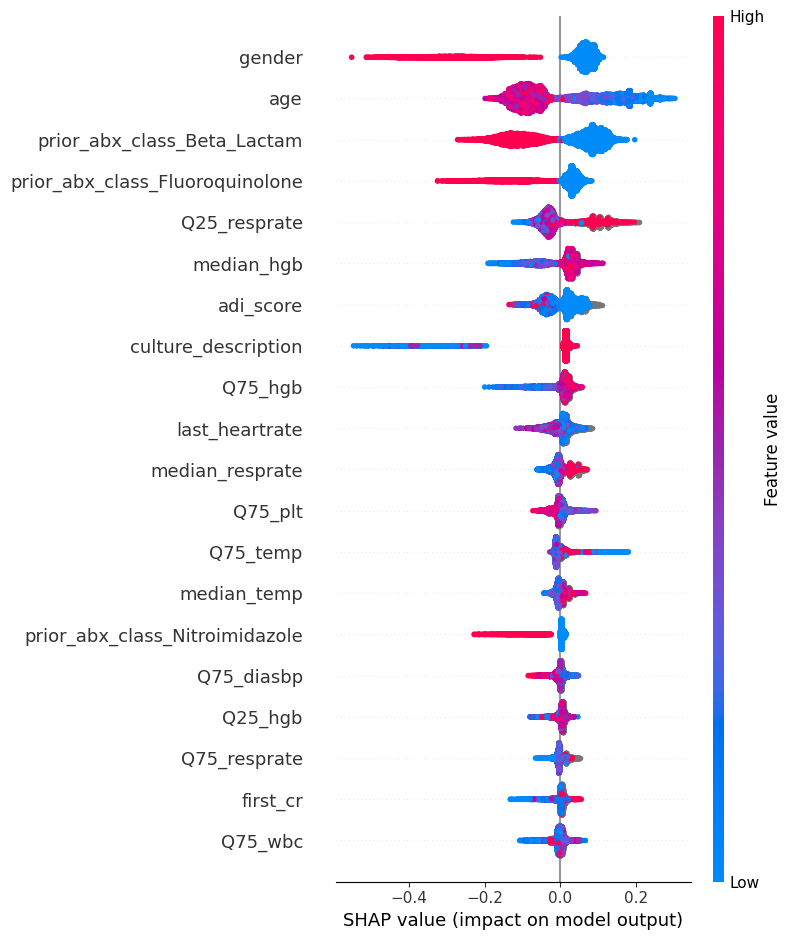

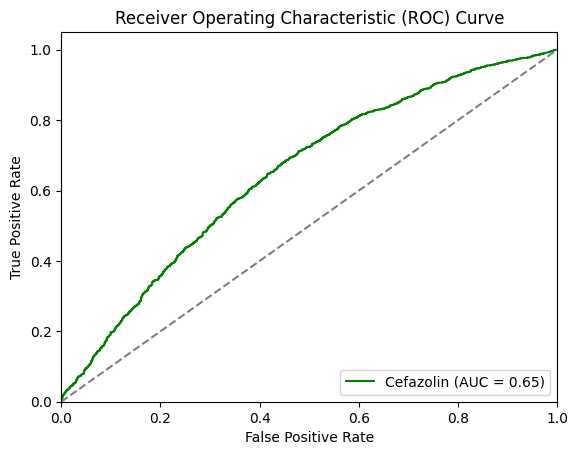

In [ ]:
def plot_shap_importance(model):
    features = model['model'].feature_name()
    print(model['df_train'].columns )
    print('**************')
    print(model['df_test'].columns )
    model['df_train'].columns = model['df_train'].columns.str.replace(' ', '_')
    model['df_test'].columns = model['df_test'].columns.str.replace(' ', '_')

    X_train = model['df_train'][features]
    X_test = model['df_test'][features]

    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

    explainer = shap.Explainer(model['model'])

    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)

#plot_shap_importance(model_ciprofloxacin)
#plot_shap_importance(model_piperacillin)
plot_shap_importance(model_cefazolin)
#plot_shap_importance(model_ceftriaxone)
#plot_shap_importance(model_cefepime)

### plot model metrics
#fpr1, tpr1 = model_ciprofloxacin['roc']['fpr'], model_ciprofloxacin['roc']['tpr']
#fpr2, tpr2 = model_piperacillin['roc']['fpr'], model_piperacillin['roc']['tpr']
fpr3, tpr3 = model_cefazolin['roc']['fpr'], model_cefazolin['roc']['tpr']
#fpr4, tpr4 = model_ceftriaxone['roc']['fpr'], model_ceftriaxone['roc']['tpr']
#fpr5, tpr5 = model_cefepime['roc']['fpr'], model_cefepime['roc']['tpr']

#roc_auc1 = auc(fpr1, tpr1)
#roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
#roc_auc4 = auc(fpr4, tpr4)
#roc_auc5 = auc(fpr5, tpr5)

plt.figure()

# plot ciprofloxacin model
#plt.plot(fpr1, tpr1, color='red', label=f'Ciprofloxacin (AUC = {roc_auc1:.2f})')

# plot piperacillin model
#plt.plot(fpr2, tpr2, color='blue', label=f'Piperacillin (AUC = {roc_auc2:.2f})')

# plot cefazolin model
plt.plot(fpr3, tpr3, color='green', label=f'Cefazolin (AUC = {roc_auc3:.2f})')

# plot ceftriaxone model
#plt.plot(fpr4, tpr4, color='orange', label=f'Ceftriaxone (AUC = {roc_auc4:.2f})')

# plot cefepime model
#plt.plot(fpr5, tpr5, color='purple', label=f'Cefepime (AUC = {roc_auc5:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
